# BIG DATA PROJECT (PRACTICE PROJECT - REFERENCE FOR LEARNING)


## Amazon review and sentiment analysis using aws sample files (Text classification)


#### Author: 
#### Amandeep (A20466752)
#### Rutul (A20476293)
#### Amit (A20470263)


##### As a part of understanding the workings of the SageMaker, we implement a practice project on sagemaker prior to our actual project implementation. In this practice project we used the follow source as base [1] and executed sentiment analysis and text categorization on Amazon Review dataset available publicly. This dataset was clean and easy to work on.

In [1]:

import boto3
import pandas as pd
import numpy as np
import sagemaker
print(f'SageMaker version: {sagemaker.__version__}')

SageMaker version: 2.70.0


In [2]:
role = sagemaker.get_execution_role()

#source default session parameters (region, default S3 bucket etc)
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
s3_client = boto3.client('s3', region_name=region)
sagemaker_client = boto3.client("sagemaker-runtime")
default_bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker-pipelines-nlp-demo'

In [3]:
!mkdir -p data
!wget https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/womens_clothing_ecommerce/Womens_Clothing_E-Commerce_Reviews.csv -O 'data/Womens Clothing E-Commerce Reviews.csv'


--2021-12-09 04:21:22--  https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/womens_clothing_ecommerce/Womens_Clothing_E-Commerce_Reviews.csv
Resolving sagemaker-sample-files.s3.amazonaws.com (sagemaker-sample-files.s3.amazonaws.com)... 52.217.197.41
Connecting to sagemaker-sample-files.s3.amazonaws.com (sagemaker-sample-files.s3.amazonaws.com)|52.217.197.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8483448 (8.1M) [text/csv]
Saving to: ‘data/Womens Clothing E-Commerce Reviews.csv’

data/Womens Clothin 100%[===================>]   8.09M  10.2MB/s    in 0.8s    

2021-12-09 04:21:23 (10.2 MB/s) - ‘data/Womens Clothing E-Commerce Reviews.csv’ saved [8483448/8483448]



In [4]:
df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv',  index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


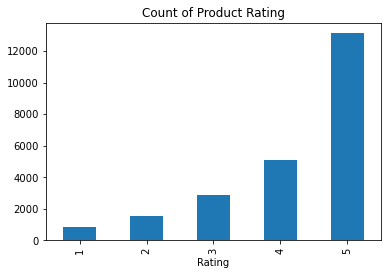

In [5]:
plot = df.groupby('Rating')['Rating'].count().plot(kind='bar', title = 'Count of Product Rating')

In [6]:
#upload the data to your default S3 bucket or another S3 bucket of your choosing
local_path = "data/Womens Clothing E-Commerce Reviews.csv"

base_uri = f"s3://{default_bucket}/{prefix}/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(input_data_uri)



s3://sagemaker-us-east-2-785516319285/sagemaker-pipelines-nlp-demo/data/Womens Clothing E-Commerce Reviews.csv


In [7]:
from sagemaker.workflow.parameters import (ParameterInteger, ParameterString)

#specify location of input data
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)

#specify default number of instances for processing step
processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)

#specify default instance type for processing step
processing_instance_type = ParameterString(
    name="ProcessingInstanceType",
    default_value="ml.m4.xlarge"
)

#specify default instance type for training step
train_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.m4.xlarge",
)

#specify default model approval mode
model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="Approved"
)




In [8]:
!mkdir -p code



In [9]:
%%writefile code/preprocessing.py

import numpy as np
import pandas as pd
import string
from sklearn.utils import resample

base_dir = "/opt/ml/processing"

df = pd.read_csv( f"{base_dir}/input/Womens Clothing E-Commerce Reviews.csv")
df = df[df['Review Text'].notna()] # drop rows where Review text is missing

def process_review(text):
    punctuation = string.punctuation
    review = text.lower()
    review = review.replace("\r\n", " ").replace("\n\n", " ")
    translator = str.maketrans("","", punctuation)
    review  = review.translate(translator)
    return review

# create columns for concat reviews and new labels
df['Complete_Review'] = df['Title'] + ' ' + df['Review Text']
df = df[df['Complete_Review'].notna()] # drop rows where review text is missing
df['Label'] = df['Rating'].map({1:'negative',2:'negative',3:'none',4:'none',5:'positive'})
df = df.loc[df['Label'].isin(['negative','positive'])] # only use positive and negative reviews
df['Review'] = df['Complete_Review'].astype(str).apply(process_review)
df['Processed'] = '__label__' + df['Label'].astype(str) + ' ' + df['Review']

# create train:test split
train, validation, test = np.split(df, [int(0.7 * len(df)), int(0.85 * len(df))])

# deal with unbalanced classes
# only include resampling for training set so no data leakeage for validation sets
positive = train.loc[train['Label']=='positive']
negative = train.loc[train['Label']=='negative']

# oversample the minority classes
negative_oversample = resample(negative, replace=True, n_samples=len(positive))

# remake training set using balanced class camples
train = pd.concat([positive,negative_oversample])

# create Series datasets for BlazingText format
train = train['Processed']
validation = validation['Processed']
test = test['Processed']

# save datasets
pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"{base_dir}/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

print(f"Number of reviews in the training dataset: {train.shape[0]}")
print(f"Number of reviews in the validation set: {validation.shape[0]}")

Writing code/preprocessing.py


In [10]:
from sagemaker.sklearn.processing import SKLearnProcessor

framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="sklearn-nlp-process",
    role=role,
)

In [11]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

s3_client.upload_file(Filename='./code/preprocessing.py', Bucket=default_bucket, Key=f'{prefix}/code/preprocessing.py')
preprocess_script_uri = f's3://{default_bucket}/{prefix}/code/preprocessing.py'

process_step = ProcessingStep(
    name="BTDemoProcessStep",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code=preprocess_script_uri,
)

In [12]:
# set up estimator:

from sagemaker.estimator import Estimator

bt_estimator = Estimator(
    role=role,
    instance_type=train_instance_type,
    instance_count=1,
    image_uri=sagemaker.image_uris.retrieve("blazingtext", region),
    output_path=f's3://{default_bucket}/{prefix}/training_jobs',
    base_job_name='bt-model-estimator',
    input_mode = 'File'
)

#for more info on hyperparameters, see: https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html
bt_estimator.set_hyperparameters(mode="supervised",
                                 epochs=25,
                                 learning_rate=0.02,
                                 min_count=2,
                                 early_stopping=True,
                                 patience=4,
                                 min_epochs=10,
                                 word_ngrams=3
                                )

In [13]:
# set up model training step
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

train_step = TrainingStep(
    name='BTDemoTrainStep',
    estimator=bt_estimator,
    inputs={
        'train': sagemaker.inputs.TrainingInput(
            s3_data=process_step.properties.ProcessingOutputConfig.Outputs['train'].S3Output.S3Uri,
            content_type="text/csv"
        ),
        'validation': sagemaker.inputs.TrainingInput(
            s3_data=process_step.properties.ProcessingOutputConfig.Outputs['test'].S3Output.S3Uri,
            content_type="text/csv"
        )
    }
)

In [14]:
from sagemaker.workflow.steps import CreateModelStep

model = sagemaker.model.Model(
    name='nlp-blaztext-model',
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role
)

inputs = sagemaker.inputs.CreateModelInput(
    instance_type="ml.m4.xlarge"
)

create_model_step = CreateModelStep(
    name="BTDemoCreatemodelStep",
    model=model,
    inputs=inputs
)

In [15]:
%%writefile code/deploy_model.py

import time
from datetime import datetime
import boto3
import argparse


# Parse argument variables passed via the DeployModel processing step
parser = argparse.ArgumentParser()
parser.add_argument('--model-name', type=str)
parser.add_argument('--region', type=str)
parser.add_argument('--endpoint-instance-type', type=str)
parser.add_argument('--endpoint-name', type=str)
args = parser.parse_args()

region = args.region
boto3.setup_default_session(region_name=region)
sagemaker_boto_client = boto3.client('sagemaker')

# truncate name per sagameker length requirememnts (63 char max) if necessary
endpoint_config_name = f'{args.endpoint_name}-config-{datetime.now().strftime("%Y%m%d-%H%M%S")}'

# create new endpoint config file
create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': args.endpoint_instance_type,
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': args.model_name,
        'VariantName': 'AllTraffic'
        }])

print("ModelName: {}".format(args.model_name))

# create endpoint if model endpoint does not already exist, otherwise update the endpoint
try:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=endpoint_config_name
    )
except:
    create_endpoint_response = sagemaker_boto_client.update_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=endpoint_config_name
    )

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
endpoint_status = endpoint_info['EndpointStatus']

while endpoint_status != 'InService':
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
    endpoint_status = endpoint_info['EndpointStatus']
    print('Endpoint status:', endpoint_status)
    if endpoint_status != 'InService':
        time.sleep(30)

Writing code/deploy_model.py


In [16]:
s3_client.upload_file(Filename='./code/deploy_model.py', Bucket=default_bucket, Key=f'{prefix}/code/deploy_model.py')
deploy_model_script_uri = f's3://{default_bucket}/{prefix}/code/deploy_model.py'
pipeline_endpoint_name = 'nlp-blaztext-model-endpoint'

deployment_instance_type = "ml.m4.xlarge"

deploy_model_processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    volume_size_in_gb=60,
    base_job_name='nlp-blaztext-deploy-model',
    sagemaker_session=sagemaker_session)

deploy_step = ProcessingStep(
    name='BTDemoDeployStep',
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name", create_model_step.properties.ModelName,
        "--region", region,
        "--endpoint-instance-type", deployment_instance_type,
        "--endpoint-name", pipeline_endpoint_name
    ],
    code=deploy_model_script_uri)

In [17]:
from sagemaker.workflow.step_collections import RegisterModel

register_step = RegisterModel(
    name="BTDemoRegistermodelStep",
    estimator=bt_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=prefix,
    approval_status=model_approval_status,
)

In [18]:
from sagemaker.workflow.pipeline import Pipeline

#run full pipeline
steps_full = [process_step,
              train_step,
              create_model_step,
              deploy_step,
              register_step]

#run data processing step
steps_preprocessing = [process_step]

pipeline_name = 'BlazingTextPipeline'

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        train_instance_type,
        model_approval_status,
        input_data
    ],
    steps=steps_full, #switch to steps_preprocessing if you would like to run only the data processing step
)

In [19]:
import json

definition = json.loads(pipeline.definition())
definition

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m4.xlarge'},
  {'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m4.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'Approved'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-2-785516319285/sagemaker-pipelines-nlp-demo/data/Womens Clothing E-Commerce Reviews.csv'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'BTDemoProcessStep',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': {'Get': 'Parameters.ProcessingInstanceType'},
      'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'},
      'VolumeSi

In [20]:
pipeline.upsert(role_arn=role)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'PipelineArn': 'arn:aws:sagemaker:us-east-2:785516319285:pipeline/blazingtextpipeline',
 'ResponseMetadata': {'RequestId': '2728447d-75b8-4c84-b9a2-47b78f7af583',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2728447d-75b8-4c84-b9a2-47b78f7af583',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '87',
   'date': 'Thu, 09 Dec 2021 04:24:27 GMT'},
  'RetryAttempts': 0}}

In [21]:
execution = pipeline.start()

In [22]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-2:785516319285:pipeline/blazingtextpipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-2:785516319285:pipeline/blazingtextpipeline/execution/gb89ius4dtab',
 'PipelineExecutionDisplayName': 'execution-1639023874392',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'blazingtextpipeline',
  'TrialName': 'gb89ius4dtab'},
 'CreationTime': datetime.datetime(2021, 12, 9, 4, 24, 34, 285000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 12, 9, 4, 24, 34, 285000, tzinfo=tzlocal()),
 'CreatedBy': {},
 'LastModifiedBy': {},
 'ResponseMetadata': {'RequestId': '7deba880-0baf-40ea-a7bd-36c50a9a5cdf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7deba880-0baf-40ea-a7bd-36c50a9a5cdf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '498',
   'date': 'Thu, 09 Dec 2021 04:24:37 GMT'},
  'RetryAttempts': 0}}

In [23]:
execution.wait()

In [24]:
execution.list_steps()

[{'StepName': 'BTDemoDeployStep',
  'StartTime': datetime.datetime(2021, 12, 9, 4, 36, 9, 515000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2021, 12, 9, 4, 42, 55, 447000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-2:785516319285:processing-job/pipelines-gb89ius4dtab-btdemodeploystep-oznlpc1zt5'}}},
 {'StepName': 'BTDemoCreatemodelStep',
  'StartTime': datetime.datetime(2021, 12, 9, 4, 36, 7, 990000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2021, 12, 9, 4, 36, 9, 160000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-2:785516319285:model/pipelines-gb89ius4dtab-btdemocreatemodelste-algle9lgtp'}}},
 {'StepName': 'BTDemoRegistermodelStep',
  'StartTime': datetime.datetime(2021, 12, 9, 4, 36, 7, 990000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2021, 12, 9, 4, 36, 9, 114000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata':

In [25]:
import string

def process_review(text):
    punctuation = string.punctuation
    review = text.lower()
    review = review.replace("\r\n", " ").replace("\n\n", " ")
    translator = str.maketrans("","", punctuation)
    review  = review.translate(translator)
    return review

In [26]:
sentences = ["i loved this blouse when i saw it on-line, and the fabric is so soft!",
             "love the top, but very small to the size. ordered a medium and had to send back in exchange for x-large",
             "horrible! this top was scratchy and too small."]
# process the reviews to predict the same as training data
processed_sentences = [ process_review(sent) for sent in sentences ]

payload = {"instances" : processed_sentences}

In [27]:
def get_predictions(payload, endpoint_name, client):
    response = client.invoke_endpoint(EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType='application/json')
    predictions = json.loads(response['Body'].read().decode('utf-8'))
    return list(zip(payload['instances'], predictions))

In [28]:
get_predictions(payload, pipeline_endpoint_name, sagemaker_client)

[('i loved this blouse when i saw it online and the fabric is so soft',
  {'label': ['__label__positive'], 'prob': [0.9730098247528076]}),
 ('love the top but very small to the size ordered a medium and had to send back in exchange for xlarge',
  {'label': ['__label__positive'], 'prob': [0.6169371008872986]}),
 ('horrible this top was scratchy and too small',
  {'label': ['__label__negative'], 'prob': [0.9998633861541748]})]